In [2]:
import numpy as np
import pandas as pd
from holidays import country_holidays
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error
from datetime import timedelta
import itertools
import matplotlib.pyplot as plt
from scipy.stats import uniform 
import joblib
import os

# Load and prepare the dataset

In [98]:
# Load and prepare the dataset
df = pd.read_csv('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/data/day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)

# Sort dataframe by date in descending order
df = df.sort_values(by='Datetime', ascending=False).reset_index(drop=True)

# Filter data up to 30th October 2024
df = df[df['Datetime'] <= '2024-10-29 23:59:00']

# Filter data for the last 6 months
end_date = df['Datetime'].max()
start_date = end_date - timedelta(days=180)
df = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)].reset_index(drop=True)

# Rename columns to fit Prophet requirements
df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)
# actual 29th October 2024
actual_29th = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]

#outliers clipped
upper_threshold = (df['y'].mean() + 3 * df['y'].std())  # upper threshold
lower_threshold = df['y'].mean() - 3 * df['y'].std()  # lower threshold

# Clip outliers
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

# Fourier Order including Actual Data

In [99]:
model = Prophet(
 #   growth= 'linear',
 #   daily_seasonality=True,  # Turn off daily seasonality (add custom seasonality)
 #   yearly_seasonality=True,  # Allow yearly seasonality for longer trends
    weekly_seasonality=True,  # Allow weekly seasonality
 #   changepoint_prior_scale=0.05, # Default changepoint flexibility
    n_changepoints= 7,
 #   seasonality_mode= 'additive',
 #   seasonality_prior_scale = 0.01,
 #   holidays_prior_scale = 0.01,

)
# Adding custom seasonalities
model.add_seasonality(name='hourly', period=1, fourier_order=480)
model.add_seasonality(name='daily', period=24, fourier_order=50)
#model.add_seasonality(name='weekly', period=7*24, fourier_order=7)
model.add_seasonality(name='monthly', period=30.5*24, fourier_order=500)
model.add_seasonality(name='yearly', period=365.25, fourier_order=1000)

# Fit the model
model.fit(df)
future = pd.date_range(start='2024-10-29 00:00:00', end='2024-10-29 23:59:00', freq='h')
future_df = pd.DataFrame({'ds': future})

# Forecast the future values
forecast = model.predict(future_df)

# Merge actual and forecast data for October 29th
actual_29th = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
merged_data = pd.merge(actual_29th[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate RMSE for October 29th
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for October 29th, 2024: {rmse}")

15:33:46 - cmdstanpy - INFO - Chain [1] start processing
15:34:20 - cmdstanpy - INFO - Chain [1] done processing


RMSE for October 29th, 2024: 5.753559566263798


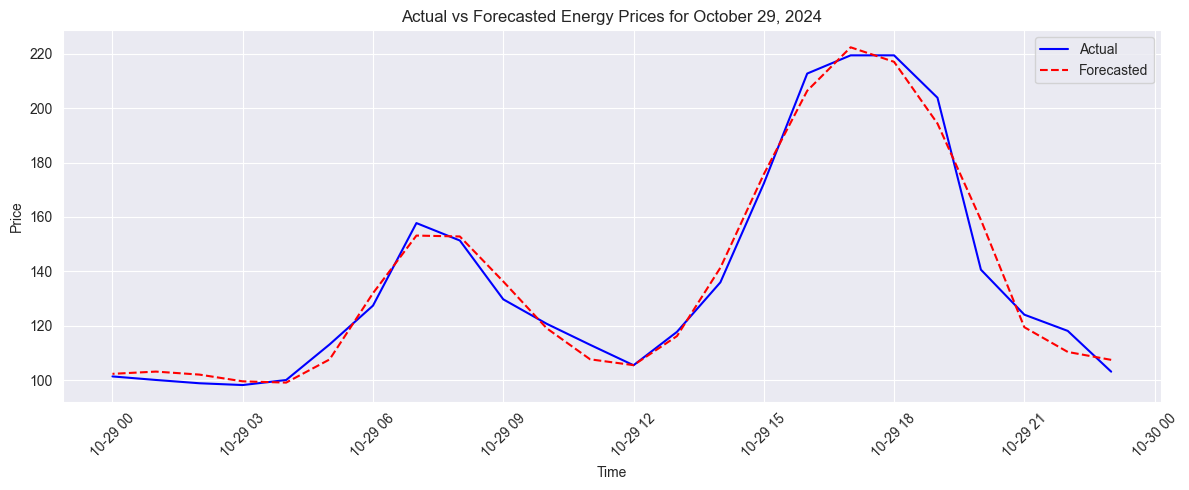

RMSE for October 29th, 2024: 5.753559566263798


In [107]:
# Plot the forecast vs actual prices
plt.figure(figsize=(12, 5))
plt.plot(merged_data['ds'], merged_data['y'], label='Actual', color='blue')
plt.plot(merged_data['ds'], merged_data['yhat'], label='Forecasted', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for October 29, 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print the RMSE
print(f"RMSE for October 29th, 2024: {rmse}")

## pickle

In [109]:
from datetime import datetime
import pickle
import os
import matplotlib.pyplot as plt
import json

# Create timestamp for unique folder naming
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
rmse_str = f"{rmse:.2f}"  # Format RMSE with two decimal points

# Define directory for this model
base_dir = '/Users/zeynepkaya/PycharmProjects/LSDI-Project-/models/Prophet/pickle'
model_dir = os.path.join(base_dir, f"model_{rmse_str}_rmse_{ts}")
os.makedirs(model_dir, exist_ok=True)

# Save Prophet model to the directory
pickle_path = os.path.join(model_dir, 'model.pickle')
with open(pickle_path, "wb") as file:
    pickle.dump(model, file)

# Collect all hyperparameters from the model
hyperparams = {
    'growth': model.growth,
    'changepoint_prior_scale': model.changepoint_prior_scale,
    'seasonality_mode': model.seasonality_mode,
    'daily_seasonality': model.daily_seasonality,
    'yearly_seasonality': model.yearly_seasonality,
    'weekly_seasonality': model.weekly_seasonality,
    'seasonality_prior_scale': model.seasonality_prior_scale,
    'holidays_prior_scale': model.holidays_prior_scale,
    'n_changepoints': model.n_changepoints,
    'seasonalities': model.seasonalities,  # Custom seasonalities
    'holidays': model.holidays.to_json() if model.holidays is not None else None  # Convert holidays to JSON if present
}

# Save hyperparameters to JSON file
json_path = os.path.join(model_dir, 'hyperparams.json')
with open(json_path, 'w') as json_file:
    json.dump(hyperparams, json_file, indent=4)

# Plot Actual vs Forecasted and save
plt.figure(figsize=(10, 6))
plt.plot(merged_data['ds'], merged_data['y'], label='Actual', color='blue')
plt.plot(merged_data['ds'], merged_data['yhat'], label='Forecasted', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for October 29, 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Save the plot as an image
plot_path = os.path.join(model_dir, 'actual_vs_forecast.png')
plt.savefig(plot_path)
plt.close()


# Fourier Order NOT including Actual Data

## prepare data

In [110]:
# Load and prepare the dataset
df = pd.read_csv('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/data/day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df = df.sort_values(by='Datetime', ascending=False).reset_index(drop=True)

df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)

# Keep 29th october actual data
#actual_data = df[df['ds'] <= '2024-10-29 23:59:00']

# Filter data up to 30th October 2024
df = df[df['ds'] <= '2024-10-29 23:59:00']
end_date = df['ds'].max()
start_date = end_date - timedelta(days=180)
df = df[(df['ds'] >= start_date) & (df['ds'] <= end_date)].reset_index(drop=True)

#outliers clipped
upper_threshold = (df['y'].mean() + 3 * df['y'].std())  # upper threshold
lower_threshold = df['y'].mean() - 3 * df['y'].std()  # lower threshold

# Clip outliers
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

# Split data: Use the last 20% as test data, and the first 80% as training data
split_index = int(len(df) * 0.2)  # 80% for training, 20% for testing
test_data = df[:split_index]  # First 80% for training
train_data = df[split_index:]   # Remaining 20% for testing


## model

In [111]:
# Initialize and configure the Prophet model
model = Prophet(
    growth= 'linear',
    daily_seasonality=False,  # Turn off daily seasonality (add custom seasonality)
   # yearly_seasonality=True,  # Allow yearly seasonality for longer trends
   # weekly_seasonality=True,  # Allow weekly seasonality
    changepoint_prior_scale=0.001, # Default changepoint flexibility
    n_changepoints= 20,
    seasonality_mode= 'additive',
    seasonality_prior_scale = 0.01,
    holidays_prior_scale = 0.01,

)

# Add custom seasonalities
model.add_seasonality(name='hourly', period=1, fourier_order=20)
model.add_seasonality(name='daily', period=24, fourier_order=4)
#model.add_seasonality(name='weekly', period=7*24, fourier_order=10)
model.add_seasonality(name='monthly', period=30.5*24, fourier_order=30)
model.add_seasonality(name='yearly', period=365.25*24, fourier_order=15)

# Fit the model on the training data
model.fit(train_data)

# Define future dates for forecasting (test period)
future_df = test_data[['ds']]  # Using the test data for future forecasting

# Forecast the future values (test period)
forecast = model.predict(future_df)

# Merge actual and forecast data for comparison
merged_data = pd.merge(test_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Filter merged_data to include only the data for 29th October 2024
merged_data_29th = merged_data[(merged_data['ds'] >= '2024-10-29 00:00:00') & (merged_data['ds'] <= '2024-10-29 23:59:59')]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for the test period: {rmse}")

rmse_29th_october = np.sqrt(mean_squared_error(merged_data_29th['y'], merged_data_29th['yhat']))
print(f"RMSE for 29th October 2024: {rmse_29th_october}")



15:38:59 - cmdstanpy - INFO - Chain [1] start processing
15:38:59 - cmdstanpy - INFO - Chain [1] done processing


RMSE for the test period: 43.97530621710531
RMSE for 29th October 2024: 59.07079140135381


## Plot

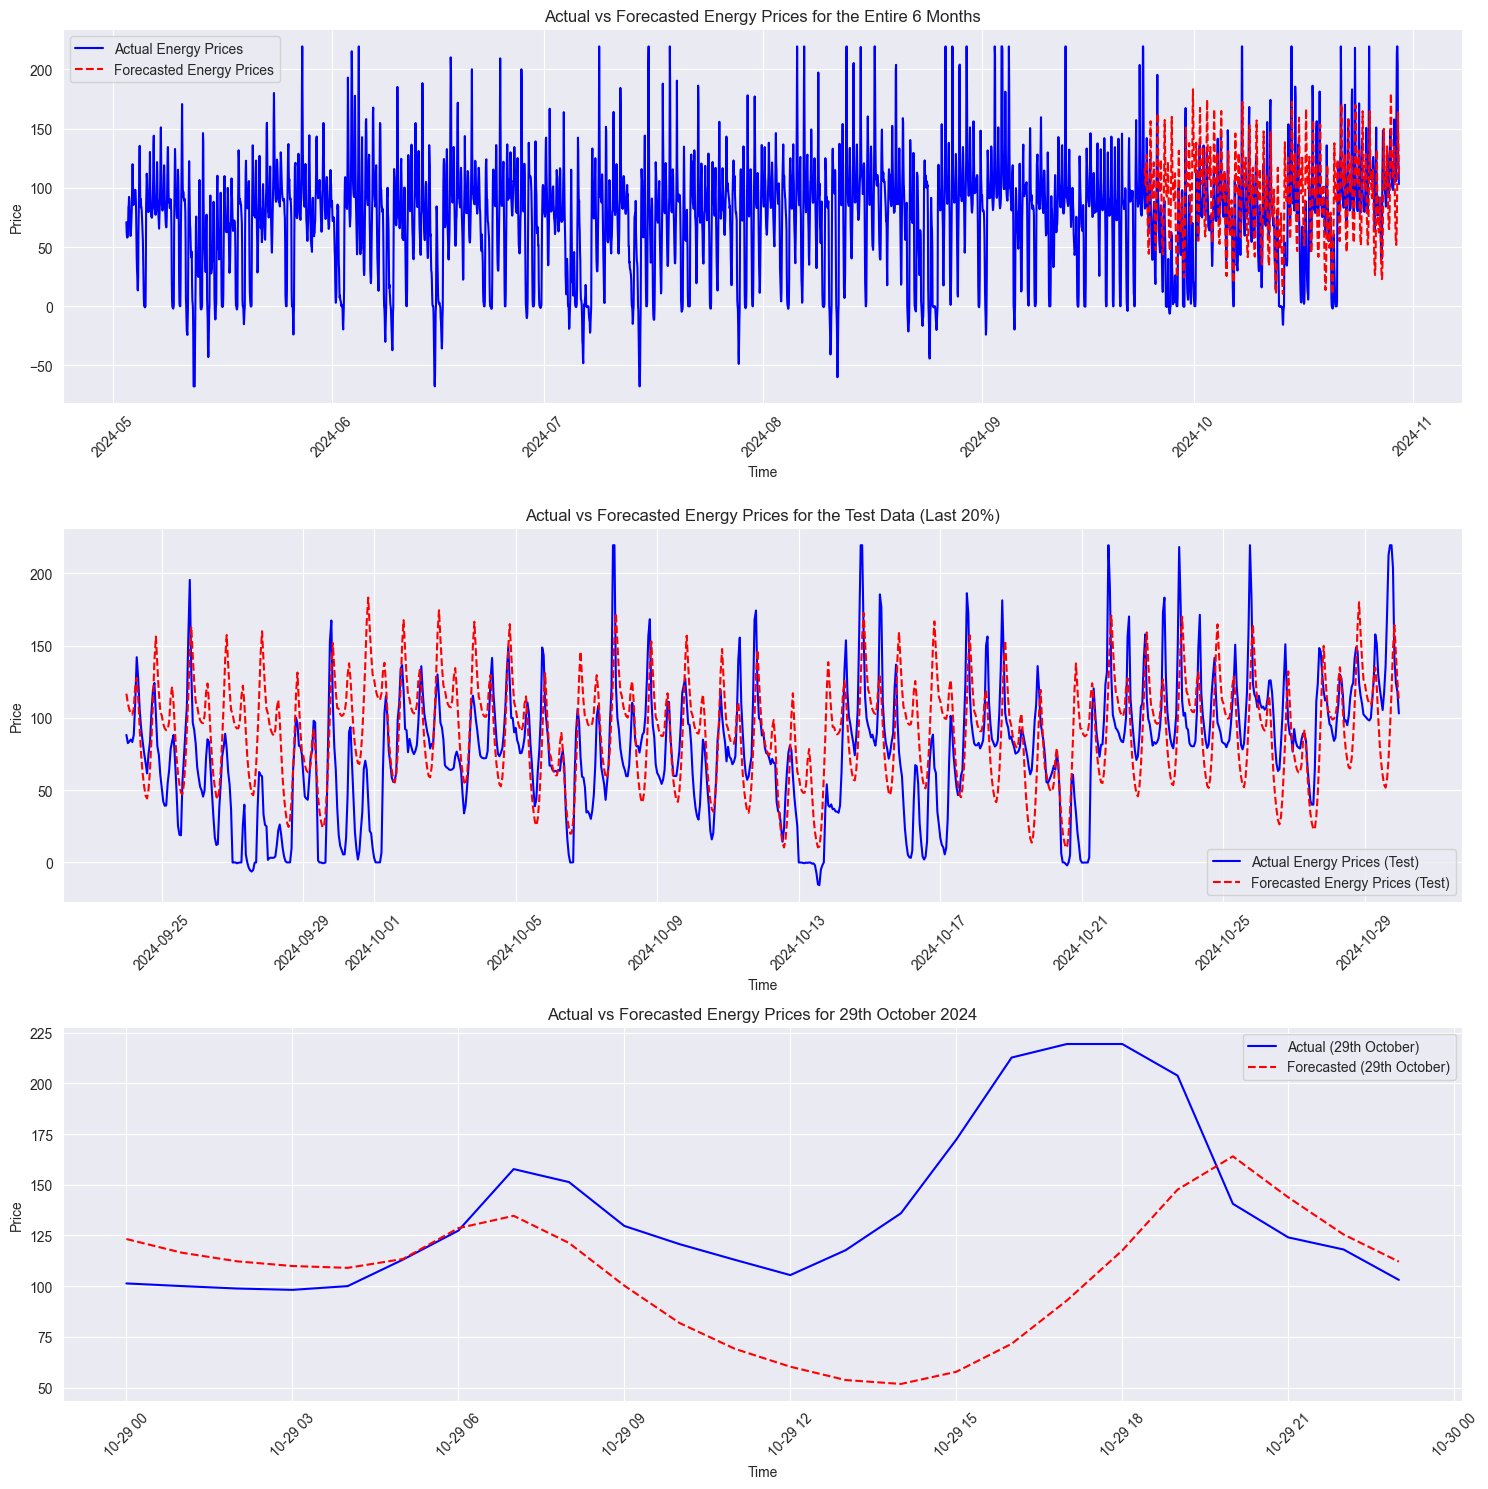

In [112]:
# Plot the entire data with forecasted and actual values
plt.figure(figsize=(15, 15))

# Plot entire data (train + test) with forecast and actual values
plt.subplot(3, 1, 1)
plt.plot(df['ds'], df['y'], label='Actual Energy Prices', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for the Entire 6 Months")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Plot only test data (last 20%)
plt.subplot(3, 1, 2)
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices (Test)', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for the Test Data (Last 20%)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Plot 29th October 2024 data separately
october_29th_data = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
forecast_29th_october = forecast[forecast['ds'].isin(october_29th_data['ds'])]

plt.subplot(3, 1, 3)
plt.plot(october_29th_data['ds'], october_29th_data['y'], label='Actual (29th October)', color='blue')
plt.plot(forecast_29th_october['ds'], forecast_29th_october['yhat'], label='Forecasted (29th October)', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for 29th October 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()


plt.tight_layout()
plt.show()


### pickle

In [113]:
from datetime import datetime
import pickle
import os
import matplotlib.pyplot as plt
import json

# Create timestamp for unique folder naming
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
rmse_str = f"{rmse:.2f}"  # Format RMSE with two decimal points

# Define directory for this model
base_dir = '/Users/zeynepkaya/PycharmProjects/LSDI-Project-/models/Prophet/pickle'
model_dir = os.path.join(base_dir, f"model_{rmse_str}_rmse_{ts}")
os.makedirs(model_dir, exist_ok=True)

# Save Prophet model to the directory
pickle_path = os.path.join(model_dir, 'model.pickle')
with open(pickle_path, "wb") as file:
    pickle.dump(model, file)

# Collect all hyperparameters from the model
hyperparams = {
    'growth': model.growth,
    'changepoint_prior_scale': model.changepoint_prior_scale,
    'seasonality_mode': model.seasonality_mode,
    'daily_seasonality': model.daily_seasonality,
    'yearly_seasonality': model.yearly_seasonality,
    'weekly_seasonality': model.weekly_seasonality,
    'seasonality_prior_scale': model.seasonality_prior_scale,
    'holidays_prior_scale': model.holidays_prior_scale,
    'n_changepoints': model.n_changepoints,
    'seasonalities': model.seasonalities,  # Custom seasonalities
    'holidays': model.holidays.to_json() if model.holidays is not None else None  # Convert holidays to JSON if present
}

# Save hyperparameters to JSON file
json_path = os.path.join(model_dir, 'hyperparams.json')
with open(json_path, 'w') as json_file:
    json.dump(hyperparams, json_file, indent=4)

# Plot Entire 6 Months with Forecasted and Actual Values
plt.figure(figsize=(15, 20))
plt.subplot(3, 1, 1)
plt.plot(df['ds'], df['y'], label='Actual Energy Prices', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for the Entire 6 Months")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Plot Test Data with Forecasted and Actual Values
plt.subplot(3, 1, 2)
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices (Test)', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for the Test Data (Last 20%)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Plot 29th October 2024 Data
october_29th_data = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
forecast_29th_october = forecast[forecast['ds'].isin(october_29th_data['ds'])]

plt.subplot(3, 1, 3)
plt.plot(october_29th_data['ds'], october_29th_data['y'], label='Actual (29th October)', color='blue')
plt.plot(forecast_29th_october['ds'], forecast_29th_october['yhat'], label='Forecasted (29th October)', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for 29th October 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Save the third plot
plot_path_29october = os.path.join(model_dir, 'actual_vs_forecast_29october.png')
plt.savefig(plot_path_29october)

# Ensure the layout is tight before closing
plt.tight_layout()
plt.close()

# Final print statement
print("All plots have been saved successfully.")


All plots have been saved successfully.


# Hyperparameter grid + Cross-Validation

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'growth': ['linear', 'logistic'],  # Trend type
    'n_changepoints': [20, 25],  # Number of changepoints
    'changepoint_prior_scale': [0.0001, 0.001, 0.1],  # Flexibility of trend changes
    'seasonality_prior_scale': [0.001, 0.01, 0.1],  # Flexibility of seasonality
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Flexibility for holidays
    'seasonality_mode': ['additive' ],  # Additive or multiplicative seasonality
    'yearly_seasonality': [True],  # Yearly seasonality toggle
    'weekly_seasonality': [True],  # Weekly seasonality toggle
    'daily_seasonality': [True],  # Daily seasonality toggle
}

# Generate all combinations of hyperparameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

best_rmse = float('inf')
best_params = None

# Iterate over all hyperparameter combinations
for params in all_params:
    try:
        # Initialize Prophet model with current parameters
        model = Prophet(
            growth=params['growth'],
            n_changepoints=params['n_changepoints'],
            changepoint_prior_scale=params['changepoint_prior_scale'], #How flexible the model is in changing trends. 
            seasonality_prior_scale=params['seasonality_prior_scale'], #How flexible the seasonal patterns are.
            holidays_prior_scale=params['holidays_prior_scale'],
            seasonality_mode=params['seasonality_mode'],
            yearly_seasonality=params['yearly_seasonality'],
            weekly_seasonality=params['weekly_seasonality'],
            daily_seasonality=params['daily_seasonality']
        )
        
        # Fit the model
        model.fit(df) 
        
        # Perform cross-validation
        df_cv = cross_validation(model, horizon='7 days', period='3 days', initial='150 days')
        
        # Evaluate performance
        df_performance = performance_metrics(df_cv)
        rmse = df_performance['rmse'].mean()
        
        # Update best parameters if current RMSE is lower
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    except Exception as e:
        print(f"Error with parameters {params}: {e}")
        continue

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")


Best Parameters: {'growth': 'linear', 'n_changepoints': 25, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True}
Best RMSE: 39.8285555057785

In [ ]:
# Train the model using the best parameters
model = Prophet(
    growth=best_params['growth'],
    n_changepoints=best_params['n_changepoints'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    yearly_seasonality=best_params['yearly_seasonality'],
    weekly_seasonality=best_params['weekly_seasonality'],
    daily_seasonality=best_params['daily_seasonality']
)

# Fit the model with the entire dataset
model.fit(df)

# Generate the future dataframe and forecast
future = model.make_future_dataframe(periods=30, freq='h')
forecast = model.predict(future)

# Save the best parameters for future use
best_params

In [ ]:
# Plot the forecast for the entire dataset (including trend line)
fig = model.plot(forecast)
plt.title("Forecast of Hourly Day-Ahead Energy Prices with Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# Plot actual vs forecast for the last 10 days
last_ten_start = df['ds'].max() - timedelta(days=10)
last_ten_end = df['ds'].max()

# Filter the actual and forecasted data for the last 10 days
actual_last_ten = df[(df['ds'] >= last_ten_start) & (df['ds'] <= last_ten_end)]
forecast_last_ten = forecast[(forecast['ds'] >= last_ten_start) & (forecast['ds'] <= last_ten_end)]

plt.figure(figsize=(14, 8))
plt.plot(actual_last_ten['ds'], actual_last_ten['y'], label='Actual Prices', marker='o', color='blue')
plt.plot(forecast_last_ten['ds'], forecast_last_ten['yhat'], label='Forecast Prices', marker='x', color='orange')
plt.fill_between(forecast_last_ten['ds'], forecast_last_ten['yhat_lower'], forecast_last_ten['yhat_upper'],
                 color='gray', alpha=0.2, label='Forecast Uncertainty')
plt.title("Actual vs Forecasted Prices for the Last 10 Days")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot actual vs forecast for October 29, 2024
actual_29th = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 22:59:59')]
forecast_29th = forecast[(forecast['ds'] >= '2024-10-29 00:00:00') & (forecast['ds'] <= '2024-10-29 22:59:59')]

plt.figure(figsize=(12, 6))
plt.plot(actual_29th['ds'], actual_29th['y'], label='Actual Prices', marker='o', color='blue')
plt.plot(forecast_29th['ds'], forecast_29th['yhat'], label='Forecast Prices', marker='x', color='orange')
plt.fill_between(forecast_29th['ds'], forecast_29th['yhat_lower'], forecast_29th['yhat_upper'],
                 color='gray', alpha=0.2, label='Forecast Uncertainty')
plt.title("Actual vs Forecasted Prices for October 29, 2024")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.show()


# Ensure both datasets have matching timestamps
actual_29th = actual_29th.sort_values('ds').reset_index(drop=True)
forecast_29th = forecast_29th.sort_values('ds').reset_index(drop=True)

# Calculate RMSE for the day
rmse_29th = np.sqrt(mean_squared_error(actual_29th['y'], forecast_29th['yhat']))
print ('For October 29, RMSE:', rmse_29th)


# saturating_forecasts.ipynb / logistic growth

In [ ]:
# Add a carrying capacity column (20% above max observed value)
df['cap'] = df['y'].max() * 1.2

# Initialize and train the logistic growth model
model = Prophet(growth='logistic', daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.5)
model.fit(df)

# Prepare future DataFrame for hourly predictions on October 29, 2024
future = pd.date_range(start="2024-10-29 00:00:00", end="2024-10-29 22:59:00", freq='h')
future = pd.DataFrame({'ds': future})
future['cap'] = df['cap'].iloc[0]  # Keep the same cap as historical data

# Generate the forecast
forecast = model.predict(future)

# Filter the actual and forecasted data for the last month
actual_last_week = df[(df['ds'] >= last_ten_start) & (df['ds'] <= last_ten_end)]
forecast_last_week = forecast[(forecast['ds'] >= last_ten_start) & (forecast['ds'] <= last_ten_end)]

plt.figure(figsize=(14, 8))
plt.plot(actual_last_week['ds'], actual_last_week['y'], label='Actual Prices', marker='o', color='blue')
plt.plot(forecast_last_week['ds'], forecast_last_week['yhat'], label='Forecast Prices', marker='x', color='orange')
plt.fill_between(forecast_last_week['ds'], forecast_last_week['yhat_lower'], forecast_last_week['yhat_upper'],
                 color='gray', alpha=0.2, label='Forecast Uncertainty')
plt.title("Actual vs Forecasted Prices for the Last Week")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Focus on October 29, 2024, predictions
plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast Prices', marker='x', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='gray', alpha=0.2, label='Forecast Uncertainty')
plt.plot(actual_29th['ds'], actual_29th['y'], label='Actual Prices', marker='o', color='blue')
plt.title("Forecasted Prices for October 29, 2024 (Logistic Growth)")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.show()

# Extract actual data for October 29, 2024
actual_29th = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
forecast_29th = forecast[(forecast['ds'] >= '2024-10-29 00:00:00') & (forecast['ds'] <= '2024-10-29 23:59:59')]
comparison = actual_29th.merge(forecast_29th[['ds', 'yhat']], on='ds', how='inner')
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
print(f"RMSE for October 29, 2024: {rmse}")


# Modeling Holidays and Special Events

In [ ]:
# Load and prepare the dataset
df = pd.read_csv('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/data/day_ahead_energy_prices.csv',parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
#end_date = df['Datetime'].max()
#start_date = end_date - timedelta(days=180)
#df = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)].reset_index(drop=True)
df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)
actual_29th = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 22:59:59')]
upper_threshold = df['y'].mean() + 3 * df['y'].std()  # upper threshold
lower_threshold = df['y'].mean() - 3 * df['y'].std()  # lower threshold
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

In [ ]:
m = Prophet(holidays=None)
m.add_country_holidays(country_name='DE')
m.fit(df)
m.train_holiday_names


In [ ]:

# Create future DataFrame for hourly predictions on October 29, 2024
future = pd.date_range(start="2024-10-29 00:00:00", end="2024-10-29 22:59:00", freq='h')
future = pd.DataFrame({'ds': future})

# Make predictions
forecast = m.predict(future)

# Filter the forecast for October 29, 2024 (hourly forecast)
forecast_29th = forecast[(forecast['ds'] >= '2024-10-29 00:00:00') & (forecast['ds'] <= '2024-10-29 22:59:59')]
actual_29th = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 22:59:59')]

# Sort both forecast and actual data by 'ds'
actual_29th = actual_29th.sort_values('ds').reset_index(drop=True)
forecast_29th = forecast_29th.sort_values('ds').reset_index(drop=True)

# Plot the forecast vs actual prices
plt.figure(figsize=(12, 6))
plt.plot(actual_29th['ds'], actual_29th['y'], label='Actual Prices', marker='o', color='blue')
plt.plot(forecast_29th['ds'], forecast_29th['yhat'], label='Forecast Prices', marker='x', color='orange')
plt.fill_between(forecast_29th['ds'], forecast_29th['yhat_lower'], forecast_29th['yhat_upper'],
                 color='gray', alpha=0.2, label='Forecast Uncertainty')
plt.title("Actual vs Forecasted Prices for October 29, 2024 (with Holidays)")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.show()

# Calculate RMSE for October 29, 2024
rmse_29th = np.sqrt(mean_squared_error(actual_29th['y'], forecast_29th['yhat']))
print(f'RMSE for October 29, 2024: {rmse_29th}')


# Treating COVID-19 lockdowns as a one-off holidays
### Whole date


In [ ]:
# Load and prepare the dataset
df = pd.read_csv('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/data/day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)

# Remove extreme outliers from the 'y' variable
upper_threshold = df['y'].mean() + 3 * df['y'].std()  # upper threshold
lower_threshold = df['y'].mean() - 2 * df['y'].std()  # lower threshold
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

# Define the lockdowns as one-off holidays
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    {'holiday': 'war', 'ds': '2022-08-24', 'lower_window': 0, 'ds_upper': '2023-08-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

In [ ]:

# Fit Prophet model with lockdowns as holidays
m2 = Prophet(holidays=lockdowns)
m2 = m2.fit(df)

# Create a future dataframe for forecasting
future2 = m2.make_future_dataframe(periods=366, freq='H')  # Generate future dates (including the forecast date range)
forecast2 = m2.predict(future2)



In [ ]:
forecast_29th = forecast2[(forecast2['ds'] >= '2024-10-29 00:00:00') & (forecast2['ds'] <= '2024-10-29 22:59:59')]
actual_29th = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 22:59:59')]
actual_29th = actual_29th.sort_values('ds').reset_index(drop=True)
forecast_29th = forecast_29th.sort_values('ds').reset_index(drop=True)
rmse_29th = np.sqrt(mean_squared_error(actual_29th['y'], forecast_29th['yhat']))
print(f'RMSE for October 29, 2024: {rmse_29th}')


# Plot the forecast and components
fig1 = m2.plot(forecast2)
plt.axhline(y=0, color='red', linestyle='--')  # Optional: highlight the 0 baseline
plt.title('Energy Prices Forecast with Lockdowns as One-Off Holidays')
plt.show()

# Plot components (trend, seasonality, holidays)
fig2 = m2.plot_components(forecast2)
plt.show()

# Optional: Visualize changepoints in the trend
from prophet.plot import add_changepoints_to_plot
fig = m2.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m2, forecast2)
plt.title('Forecast with Trend Changepoints')
plt.show()

# Plot the forecast vs actual prices
plt.figure(figsize=(12, 6))
plt.plot(actual_29th['ds'], actual_29th['y'], label='Actual Prices', marker='o', color='blue')
plt.plot(forecast_29th['ds'], forecast_29th['yhat'], label='Forecast Prices', marker='x', color='orange')
plt.fill_between(forecast_29th['ds'], forecast_29th['yhat_lower'], forecast_29th['yhat_upper'],
                 color='gray', alpha=0.2, label='Forecast Uncertainty')
plt.title("Actual vs Forecasted Prices for October 29, 2024 (with Holidays)")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.show()

# Test Train Split

In [ ]:
df = pd.read_csv('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/data/day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)

# Remove extreme outliers from the 'y' variable
upper_threshold = df['y'].mean() + 3 * df['y'].std()  # upper threshold
lower_threshold = df['y'].mean() - 2 * df['y'].std()  # lower threshold
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

#outliers clipped 
upper_threshold = df['y'].mean() + 3 * df['y'].std()  # upper threshold
lower_threshold = df['y'].mean() - 2 * df['y'].std()  # lower threshold

# Clip outliers, baskilama 
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

# Split data into train (99%) and test (1%)
df = df.sort_values(by='ds')
split_index = int(len(df) * 0.99)
train = df.iloc[:split_index]
test = df.iloc[split_index:]


# Check the size of the splits
print(f"Training data size: {len(train)}")
print(f"Testing data size: {len(test)}")

# Fit Prophet model
m = Prophet()
m.fit(train)

# Generate future dates for forecasting
future = m.make_future_dataframe(periods=len(test), freq='h')  # Forecast for the test period (next 20% of the data)
forecast = m.predict(future)

# Evaluate Model for 29th October
actual_29th = test[(test['ds'] >= '2024-10-29 00:00:00') & (test['ds'] <= '2024-10-29 22:59:59')]
forecast_29th = forecast[(forecast['ds'] >= '2024-10-29 00:00:00') & (forecast['ds'] <= '2024-10-29 22:59:59')]
comparison = actual_29th.merge(forecast_29th[['ds', 'yhat']], on='ds', how='inner')
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
print(f"RMSE for October 29th, 2024: {rmse}")


In [ ]:
# 1. All Days (Train + Test)
plt.figure(figsize=(14, 8))
plt.plot(train['ds'], train['y'], label='Actual (Train Data)', color='blue', alpha=0.5)
plt.plot(test['ds'], test['y'], label='Actual (Test Data)', color='orange', alpha=0.8)
plt.plot(forecast['ds'], forecast['yhat'], label='Prediction (Model)', color='green', linestyle='dashed')
plt.title('All Days: Actual vs Prediction')
plt.xlabel('Date')
plt.ylabel('Energy Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# 2. Test Data Only (Actual vs Prediction)
plt.figure(figsize=(14, 8))
plt.plot(test['ds'], test['y'], label='Actual (Test Data)', color='orange')
forecast_test = forecast[forecast['ds'].isin(test['ds'])]  # Match forecast with test dates
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Prediction (Test)', color='green', linestyle='dashed')
plt.title('Test Data: Actual vs Prediction')
plt.xlabel('Date')
plt.ylabel('Energy Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


# 3. October 29th Only (From Test Data)
if not actual_29th.empty and not forecast_29th.empty:
    plt.figure(figsize=(14, 8))
    plt.plot(actual_29th['ds'], actual_29th['y'], label='Actual (October 29th)', color='red')
    plt.plot(forecast_29th['ds'], forecast_29th['yhat'], label='Prediction (October 29th)', color='green', linestyle='dashed')
    plt.title('October 29th, 2024: Actual vs Prediction')
    plt.xlabel('Time')
    plt.ylabel('Energy Price')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No data available for October 29th, 2024.")

# all together (not finished)

In [ ]:
# Step 1: Load and preprocess the data
df = pd.read_csv('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/data/day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)

# Handle outliers (Clip)
upper_threshold = df['y'].mean() + 3 * df['y'].std()  # upper threshold
lower_threshold = df['y'].mean() - 2 * df['y'].std()  # lower threshold
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)
df['cap'] = df['y'].max() * 1.2  # Set carrying capacity 20% higher than max observed value


In [ ]:
# Define the lockdowns as one-off holidays
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'upper_window': 77},  # Example: 77 days long
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'upper_window': 111}, # Example: 111 days long
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'upper_window': 4},   # Example: 4 days long
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'upper_window': 13},  # Example: 13 days long
    {'holiday': 'war', 'ds': '2022-08-24', 'lower_window': 0, 'upper_window': 353}        # Example: 353 days long
])

# Convert dates to datetime format
lockdowns['ds'] = pd.to_datetime(lockdowns['ds'])
lockdowns['upper_window'] = lockdowns['upper_window'].astype(int)  # Ensure upper_window is an integer

# Create Prophet model with the lockdowns as holidays
model = Prophet(
    #growth='logistic',
    #n_changepoints=best_params['n_changepoints'],
    #changepoint_prior_scale=best_params['changepoint_prior_scale'],
    #seasonality_prior_scale=best_params['seasonality_prior_scale'],
    #holidays_prior_scale=best_params['holidays_prior_scale'],
    #seasonality_mode=best_params['seasonality_mode'],
    #yearly_seasonality=best_params['yearly_seasonality'],
    #weekly_seasonality=best_params['weekly_seasonality'],
    #daily_seasonality=best_params['daily_seasonality'],
    #holidays=lockdowns
)

# Split data into train (99%) and test (1%)
df = df.sort_values(by='ds')
split_index = int(len(df) * 0.99)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

# Add extra seasonalities
model.add_country_holidays(country_name='DE')
model.add_seasonality(name='hourly', period=24, fourier_order=35)
model.add_seasonality(name='daily', period=1, fourier_order=8)  
model.add_seasonality(name='monthly', period=30.5, fourier_order=500) 

# Fit the model
model.fit(train)


In [ ]:
# Step 6: Generate future dataframe for prediction
future = pd.date_range(start="2024-10-29 00:00:00", end="2024-10-29 22:59:00", freq='h')
future_df = pd.DataFrame({'ds': future})
future_df['cap'] = df['cap'].iloc[0]
#Ensure future has the same capacity as historical data

# Step 7: Make predictions
forecast = model.predict(future_df)

# Step 8: Evaluate RMSE for October 29, 2024
actual_29th = test[(test['ds'] >= '2024-10-29 00:00:00') & (test['ds'] <= '2024-10-29 22:59:59')]
merged_data = pd.merge(actual_29th[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# RMSE Calculation
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for October 29, 2024: {rmse}")


In [ ]:
# Step 9: Plot forecast and actual prices for comparison
plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast Prices', marker='x', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Forecast Uncertainty')
plt.plot(actual_29th['ds'], actual_29th['y'], label='Actual Prices', marker='o', color='blue')
plt.title("Forecasted vs Actual Energy Prices for October 29, 2024")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.show()
